# 텍스트 유사도
이번 장에서는 자연어 처리의 또 다른 문제인 ***텍스트 유사도*** 문제를 해결해 보겠다. 텍스트 유사도 문제란 두 문장(글)이 있을 때 두 문장 간의 유사도를 측정할 수 있는 모델을 만드는 것이다. 

# 01. 문제 소개
- 데이터 이름: Quora Question Pairs
- 데이터 용도: 텍스트 유사도 학습을 목적으로 사용한다.
- 데이터 권한: 쿼라 권한을 가지고 있으며 캐글 가입 후 데이터를 내려 받으면 문제없다.
- https://www.kaggle.com/c/quora-question-pairs/data

쿼라(Quroa)는 앞서 설명했듯이 질문과 답변을 할 수 있는 사이트다. 실제로 딥러닝에 대해 공부할 때도 쿼라의 질문들을 참고하면서 많은 공부를 할 수 있다. 쿼라의 월 사용자는 대략 1억명 정도 된다. 매일 수많은 질문들이 사이트에 올라올텐데 이 많은 질문 중에는 분명히 중복된 것들이 포함될 것이다. 

# 02. 데이터 분석과 전처리

데이터를 가지고 모델링하기 위해서는 데이터에 대한 분석과 전처리를 진행해야 한다. 데이터 분석을 통해 데이터의 특징을 파악하고 이를 바탕으로 데이터 전처리 작업을 진행한다. 여기서는 주로 ***문장의 길이***와 ***어휘 빈도 분석***을 해서 그 결과를 전처리에 적용하고자 한다. 데이터를 내려 받는 것부터 시작해서 데이터를 분석한 후 전처리하는 순서로 진행할 것이다. 

### 2-1 데이터 불러오기와 분석하기

In [1]:
# !kaggle competitions download -c quora-question-pairs

In [2]:
# import zipfile
# zipRef = zipfile.ZipFile('./quora-question-pairs.zip', 'r')
# zipRef.extractall()
# zipRef.close()

In [3]:
# import zipfile
DATA_IN_PATH = './data_in/'
# file_list = ['train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']

# for file in file_list:
#     zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
#     zipRef.extractall(DATA_IN_PATH)
#     zipRef.close()

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

In [5]:
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


데이터는 'id', 'qid1','qid2', 'question1', 'question2', 'is_duplicate' 열로 되어 있고 
- 'id'는 각 행 데이터의 고유한 인덱스 값. 
- 'qid1'과 'qid2'는 각 질문의 고유한 인덱스 값 
- 'question1', 'question2'는 각 질문의 내용을 담고 있다. 
- 'is_duplicate'는 0 또는 1을 값으로 가지는데 0이면 두개의 질문이 중복이 아니고 1이면 두개의 질문이 중복이라는 것을 의미한다.

In [6]:
print('파일 크기: ')
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file and 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기: 
test.csv                      477.59MB
train.csv                     63.4MB
sample_submission.csv         22.35MB


대부분 훈련 데이터가 평가 데이터보다 크기가 큰데, 이번에 사용할 데이터는 평가 데이터(test.csv)가 훈련 데이터(train.csv)보다 5배 더 큰것을 알 수 있다.

평가 데이터가 큰 이유는 쿼라의 경우 질문에 대해 데이터의 수가 적다면 각각을 검색을 통해 중복을 찾아내는 편법을 사용할 수 있는데, 이러한 편법을 방지하기 위해 쿼라에서 직접 컴퓨터가 만든 질문 쌍을 평가 데이터에 임의적으로 추가했기 때문이다. 

In [7]:
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

전체 학습 데이터의 개수: 404290


결과를 보면 전체 질문 쌍의 개수는 40만 개다. 판다스는 데이터프레임과 시리즈라는 자료구조를 가지고 있다. 데이터프레임이 행렬 구조라면 시리즈는 인덱스를 가지고 있는 배열이다. 지금 하나의 데이터에 두 개의 질문이 있는 구조인데, 전체 질문(두 개의 질문)을 한 번에 분석하기 위해 판다스의 시리즈를 통해 두 개의 질문을 하나로 합친다.

참고로 앞으로 진행할 분석 순서는
1. 질문 중복 분석 
2. 라벨 빈도 분석
3. 문자 분석
4. 단어 분석

In [8]:
### 1. 질문 중복 분석
train_set = pd.Series(train_data['question1'].tolist() + 
                     train_data['question2'].tolist()).astype(str)
train_set.head()


0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

이제 질문들의 중복 여부를 확인해 보자. 넘파이를 이용해 중복을 제거한 총 질문의 수와 반복해서 나오는 질문의 수를 확인한다

In [9]:
print('교육 데이터의 총 질문 수: {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 질문의 수: {}'.format(np.sum(train_set.value_counts() >1)))

교육 데이터의 총 질문 수: 537361
반복해서 나타나는 질문의 수: 111873


중복을 제거한 유일한 질문값만 확인하기 위해 넘파이의 unique 함수를 사용했고, 중복되는 질문의 정확한 개수를 확인하기 위해 2개 이상의 값을 가지는 질문인 value_counts()가 2 이상인 값의 개수를 모두 더했다. 

맷플롯립을 통해 시각화해 보자. 그래프의 크기는 너비가 12인치이고, 길이가 5인치이며 히스토그램은 'question' 값들의 개수를 보여주며 y축의 크기 범위를 줄이기 위해 log 값으로 크기를 줄인다. x축은 중복 개수이며 y값은 동일한 중복 횟수를 가진 질문의 개수를 의미한다.

/Users/keemyohaan/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


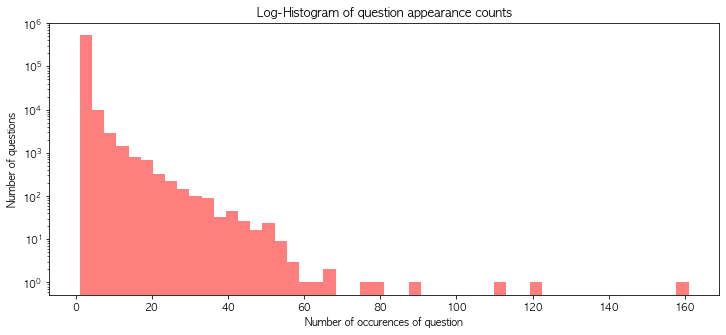

In [10]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12,5))
# bins: 히스토그램 값들에 대한 버킷 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도 
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of question appearance counts')
# 그래프 x축 라벨
plt.xlabel('Number of occurences of question')
# 그래프 y축 라벨
plt.ylabel('Number of questions')
plt.show()

[그림 5.3] 질문 중복 발생 횟수에 대한 로그 스케일 히스토그램

히스토그램을 살펴보면 우선 중복 횟수가 1인 질문들, 즉 유일한 질문이 가장 많고 대부분의 질문이 중복 횟수가 50번 이하다. 그리고 매우 큰 빈도를 가진 질문은 이상치가 될 것이다. 질문의 중복 분보플 통계치로 수치화해서 다른 방향으로 확인해보자.

In [11]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
print('제1사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제3사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 161
중복 최소 개수: 1
중복 평균 개수: 1.50472401234924
중복 표준편차: 1.9114373539609564
중복 중간길이: 1.0
제1사분위 중복: 1.0
제3사분위 중복: 1.0


중복이 발생하는 횟수의 평균이 1.5라는 것은 많은 데이터가 최소 1개 이상 중복돼 있음을 의미한다.

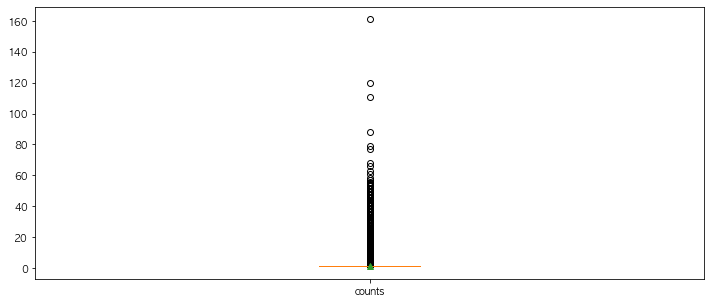

In [12]:
plt.figure(figsize=(12,5))
# 박스 플롯 생성
# 첫 번째 파라미터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([train_set.value_counts()],
           labels=['counts'],
           showmeans=True)

plt.show()

중복 횟수의 이상치(outliers)가 너무 넓고 많이 분포해서 박스플롯의 다른 값을 확인하기조차 어려운 데이터다. 앞서 확인한 데이터의 평균과 최대,최소 등을 계산한 값과 박스 플롯의 그림을 비교해보자

(-0.5, 799.5, 599.5, -0.5)

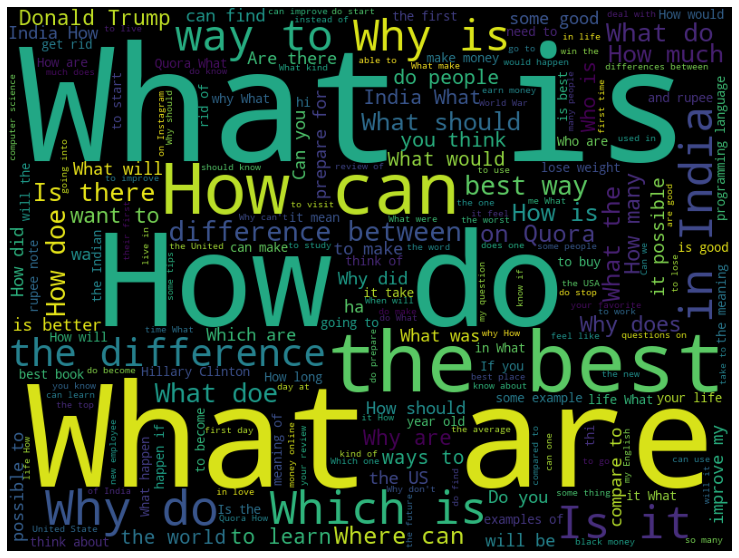

In [13]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')

이제 질문 텍스트가 아닌 데이터의 라벨인 'is_duplicate'에 대해 알아보자. 라벨의 경우 질문이 중복인 경우인 1값과 중복이 아닌 0값이 존재한다. 라벨들의 횟수에 대해 그래프를 그려보자

/Users/keemyohaan/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

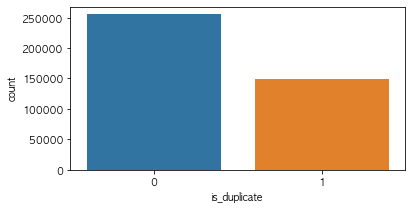

In [14]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6,3)
sns.countplot(train_data['is_duplicate'])

라벨의 개수를 확인해보면 총 40만 개의 데이터에서 중복이 아닌 데이터가 25만 개이고, 중복된 데이터가 15만 개다. 이 상태로 학습하면 중복이 아닌 데이터 25만 개의 의존도가 높아지면서 데이터가 한쪽 라벨로 편향된다.  이러한 경우 학습이 원활하게 되지 않을 수도 있으므로 최대한 라벨의 개수를 균형 있게 맞춰준 후 진행하는 것이 좋다. 
- 많은 수의 데이터를 줄인 후 학습할 수도 있고, 적은 수의 데이터를 늘린 후 학습할 수도 있다. 

In [15]:
train_length = train_set.apply(len)

Text(0, 0.5, 'Probability')

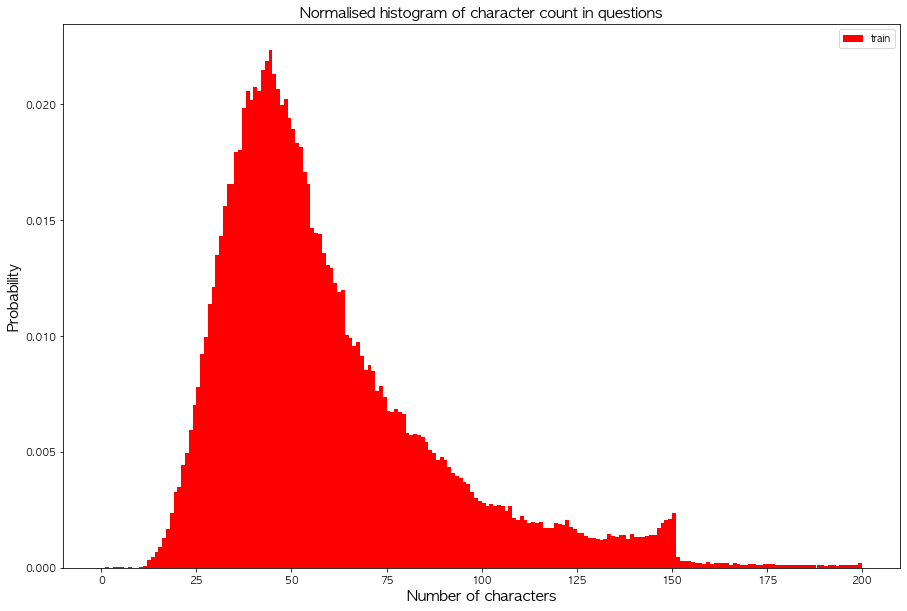

In [16]:
plt.figure(figsize=(15,10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

데이터의 각 질문이 길이 분포는 15~150에 대부분 모여 있으며 길이가 150에서 급격하게 줄어드는 것을 볼 때 쿼라의 질문 길이 제한이 150 정도라는 것을 추정해 볼 수 있다. 길이가 150 이상인 데이터는 거의 없기 때문에 해당 데이터 때문에 문제가 되지는 않을 것이다.

In [17]:
print('질문 길이 최댓값: {}'.format(np.max(train_length)))
print('질문 길이 평균값: {}'.format(np.mean(train_length)))
print('질문 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('질문 길이 중간값: {}'.format(np.median(train_length)))
print('질문 길이 제1사분위: {}'.format(np.percentile(train_length,25)))
print('질문 길이 제1사분위: {}'.format(np.percentile(train_length,75)))

질문 길이 최댓값: 1169
질문 길이 평균값: 59.82254817086745
질문 길이 표준편차: 31.96
질문 길이 중간값: 51.0
질문 길이 제1사분위: 39.0
질문 길이 제1사분위: 72.0


통곗값을 확인해 보면 우선 평균적으로 길이가 60정도라는 것을 확인할 수 있다. 
중간값의 경우 51정도다. 하지만 최댓값을 확인해보면 1169로서 평균, 중간값에 비해 매우 큰 차이를 보인다. 이런 데이터는 제외하고 학습하는 것이 좋을 것이다.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fae401b52d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae3f621ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fae401b3850>],
 'medians': [<matplotlib.lines.Line2D at 0x7fae40375290>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fae40467650>],
 'means': [<matplotlib.lines.Line2D at 0x7fae40601fd0>]}

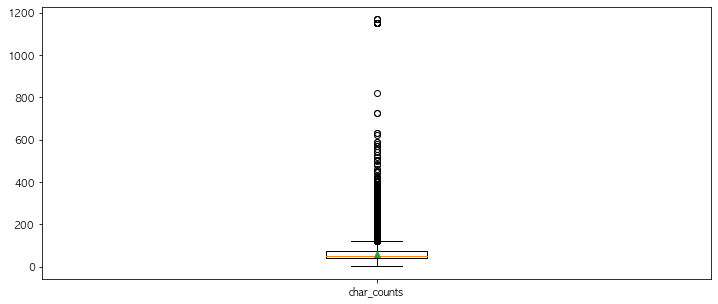

In [18]:
plt.figure(figsize=(12,5))
plt.boxplot(train_length, labels=['char_counts'], showmeans=True)


이제 문자를 한 단위로 하는 것이 아니라 각 데이터의 단어 개수를 하나의 단위로 사용해 길이값을 분석해 보자. 하나의 단어로 나누는 기준은 단순히 띄어쓰기로 정의한다. 우선 각 데이터에 대한 단어의 개수를 담은 변수를 정의하자. 

In [19]:
train_word_counts = train_set.apply(lambda x: len(x.split(' ')))

Text(0, 0.5, 'Probabiity')

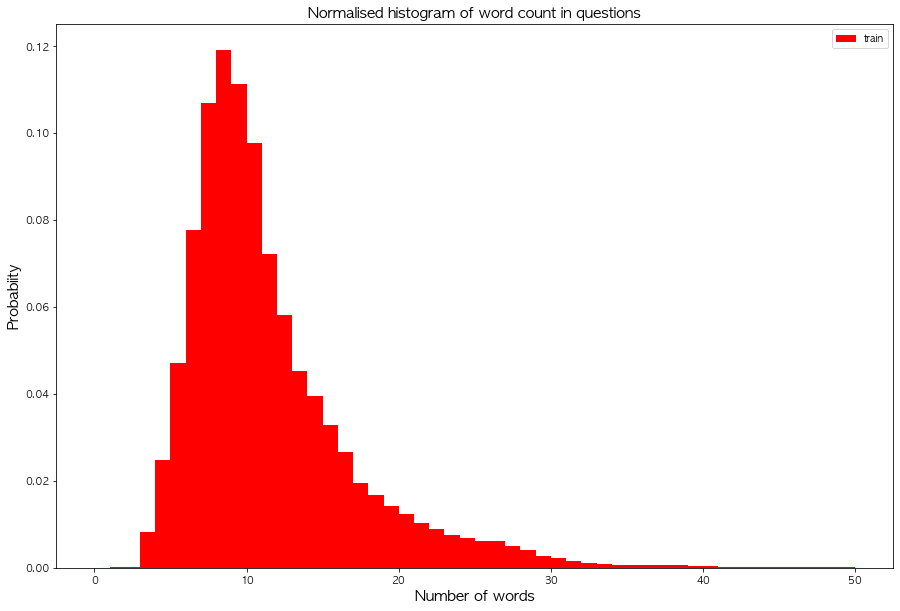

In [20]:
plt.figure(figsize=(15,10))
plt.hist(train_word_counts, bins=50, range=[0,50], facecolor='r',
        density=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probabiity', fontsize=15)

히스토그램을 보면 대부분 10개 정도의 단어로 구성된 데이터가 가장 많다는 것을 볼 수 있다. 20개 이상의 단어로 구성된 데이터는 매우 적다는 것을 확인할 수 있다.

In [21]:
print('질문 단어 개수 최댓값: {}'.format(np.max(train_word_counts)))
print('질문 단어 개수 최댓값: {}'.format(np.mean(train_word_counts)))
print('질문 단어 개수 최댓값: {}'.format(np.std(train_word_counts)))
print('질문 단어 개수 최댓값: {}'.format(np.median(train_word_counts)))

print('질문 단어 개수 최댓값: {}'.format(np.percentile(train_word_counts, 25)))
print('질문 단어 개수 최댓값: {}'.format(np.percentile(train_word_counts, 75)))
print('질문 단어 개수 최댓값: {}'.format(np.percentile(train_word_counts, 99)))

질문 단어 개수 최댓값: 237
질문 단어 개수 최댓값: 11.064855672908061
질문 단어 개수 최댓값: 5.889164008512441
질문 단어 개수 최댓값: 10.0
질문 단어 개수 최댓값: 7.0
질문 단어 개수 최댓값: 13.0
질문 단어 개수 최댓값: 31.0


데이터의 문자 단위 길이를 확인했을 때와 비슷한 양상을 보인다.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fae3c8eb210>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae3c8ebb10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fae3c8c5e10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fae3c9e1410>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fae3c9e1c90>],
 'means': [<matplotlib.lines.Line2D at 0x7fae3c9e1850>]}

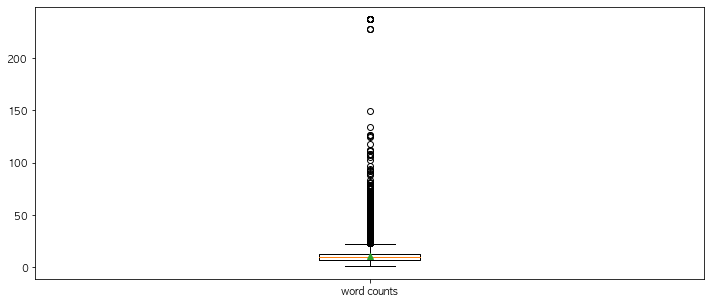

In [22]:
plt.figure(figsize=(12,5))
plt.boxplot(train_word_counts,
            labels=['word counts'],
            showmeans = True)

문자 길이에 대한 박스 플롯과 비슷한 모양의 그래프를 보여준다. 쿼라 데이터의 경우 이상치가 넓고 많이 분포돼 있음을 알 수 있다.

이제 대부분의 분석 끝났다. 마지막으로 몇 가지 특정 경우에 대한 비율을 확인해 보자. 특수 문자 중 구두점, 물음표, 마침표가 사용된 비율과 수학 기호가 사용된 비율, 대/소문자의 비율을 확인해 본다.

In [23]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) #물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) # 첫 번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개 

print('물음표가 있는 질문: {:.2f}%'.format(qmarks*100))
print('수학 태그가 있는 질문: {:.2f}%'.format(math*100))
print('질문이 가득 찼을 때: {:.2f}%'.format(fullstop*100))
print('첫 글자가 대문자인 질문: {:.2f}%'.format(capital_first*100))
print('대문자가 있는 질문: {:.2f}%'.format(capitals*100))
print('숫자가 있는 질문: {:.2f}%'.format(numbers*100))

물음표가 있는 질문: 99.87%
수학 태그가 있는 질문: 0.12%
질문이 가득 찼을 때: 6.31%
첫 글자가 대문자인 질문: 99.81%
대문자가 있는 질문: 99.95%
숫자가 있는 질문: 11.83%


문자열 토크나이징은 앞서와 동일한 방법으로 텐서플로 케라스에서 제공하는 자연어 처리 뮤들을 활용한다. 토크나이징 객체를 만들 때는 두 질문 텍스트를 합친 리스트에 대해 적용하고 토느카이징은 해당 객체를 활용해 각 질문에 대해 따로 진행한다는 것이다.

### 2-2 데이터 전처리

In [24]:
import pandas as pd
import numpy as np
import re
import json

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [25]:
DATA_IN_PATH = './data_in/'
FILTERS = "([~.,!?\"':;)(])"
MAX_SEQUENCE_LENGTH = 31

change_filter = re.compile(FILTERS)
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv', encoding='utf-8')

In [26]:
# 중복 여부에 따른 분리
train_pos_data = train_data.loc[train_data['is_duplicate']==1]
train_neg_data = train_data.loc[train_data['is_duplicate']==0]

class_difference = len(train_neg_data) - len(train_pos_data)
sample_frac = 1 - (class_difference / len(train_neg_data))

train_neg_data = train_neg_data.sample(frac=sample_frac)

먼저 라벨에 따라 질문이 유사한 경우와 아닌 경우에 대한 데이터셋으로 구분한다. 데이터프레임 객체의 loc라는 기능을 활용해 

In [28]:
print('중복 질문 개수: {}'.format(len(train_pos_data)))
print('중복이 아닌 질문 개수: {}'.format(len(train_neg_data)))

중복 질문 개수: 149263
중복이 아닌 질문 개수: 149263
